# Intuitive explaination for linear SVM usage

In this notebook, I will create an inutitive explaination of the SVM method and somewhat recreate what CIBERSORTX has used this technique for.

In [1]:
suppressWarnings({suppressPackageStartupMessages({
    library(leaps)
    library(plyr)
    library(dplyr)
    library(glmnet)
    library(data.table)
    library(MASS)
    library(MCMCprecision)
    library(parallel)
    library(ggplot2)
    library(e1071)
    })})
`%!in%` <- Negate(`%in%`)

## Idea for intuitive explaination of this process

I think a fantastic way to show the main idea behind this process is to use Kumquats! I will mathematically prove (in a fake/contrived example) that Kumquats are 70% orange and 30% grape! I will do this by taking two continuous features we know about grapes and oranges---their color and size, and plot them on a graph. Then I will put a point for an observed Kumquat. It will appear somewhere in region of a grape size (maybe larger) and more on the level of orange color. Then mathematically I want to show that the midpoint size and color of oranges and grapes can be used as inputs to a linear equation to solve that a kumquat is 70% orange and 30% grape.

Now I need to demonstrate that as we increase dimensions: number of seeds, ounces of fluid, levels of vitamin A, etc, the centroids become more and more spread out and not as good of a representation of each type of fruit. We need a way to reduce the dimensions for our two classes: SVM! It finds the best line that will seperate my two classes and bring my dimensions down from 10 to 2. Then we can just repeat what we did up above on this new reduced space, and viola we are back in buisness :)

After talking with Luke, he didn't understand the connection between a Kumquat and my bulkRNA seq. A better example would be a fruit salad or a smoothie. Which is literally a mixture.

My analogy breaks down a bit because in RNAseq, my differnet measurement variables are in the same scale and can be normalized so that the mixture is on the same level as the individual. Additionally, color has a strange property where it isn't additive. I think instead of amount of liquid, I need amount of liquid / pulp so that the smoothie can be on the same level as the individual fruits. Additionally I need not color, but maybe vitamin C content / pulp? This way were are in the same space of /pulp.

I think this is the final iteration of this thought experiment. To make the final linear deconvolution work and produce non-negative values, my two measurements need to 

## Intuitition behind deconvolution

In [2]:
set.seed(1)

vit_c_amount = c(rnorm(10, mean = 700, sd = 5), rnorm(10, mean = 400, sd = 5))
liquid_amount = c(rnorm(10, mean = 10, sd = 0.5), rnorm(10, mean = 0.5))
fruit_class = c(rep("orange", 10), rep("grape", 10))

# Oranges have 10 pulp and grapes have 1 pulp
df = data.frame(vit.c.amount = vit_c_amount, liquid.amount = liquid_amount, fruit.class = fruit_class)
head(df)

smoothie.fruits <- c(1:2,16:20)
mixture.values <- c(sum(df[smoothie.fruits,'vit.c.amount']), 
                    sum(df[smoothie.fruits,'liquid.amount'])) / length(smoothie.fruits)

,vit.c.amount,liquid.amount,fruit.class
,<dbl>,<dbl>,<chr>
1,696.8677,10.459489,orange
2,700.9182,10.391068,orange
3,695.8219,10.037282,orange
4,707.9764,9.005324,orange
5,701.6475,10.309913,orange
6,695.8977,9.971936,orange


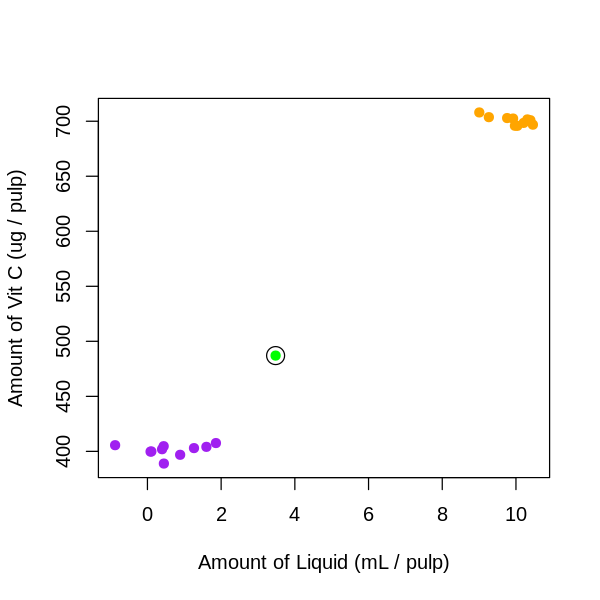

In [3]:
# Define a custom color palette with orange and purple
my_palette <- c("purple", "orange")
# Set the custom color palette using the palette() function
palette(my_palette)

options(repr.plot.height=5, repr.plot.width = 5)
plot(df$liquid.amount, df$vit.c.amount, 
     col = factor(df$fruit.class), pch = 19, 
     xlab = "Amount of Liquid (mL / pulp)", ylab = "Amount of Vit C (ug / pulp)", 
     )# xlim = c(min(df$liquid.amount),mixture.values[2]), ylim = c(min(df$vit.c.amount),mixture.values[1]))
points(c(mixture.values[2], mixture.values[2]), c(mixture.values[1], mixture.values[1]), pch = c(19, 1), col = c('green', 'black'), cex = c(1,2))

In [4]:
centroids <- sapply(df[,c("vit.c.amount", "liquid.amount")], FUN = function(x){
    tapply(x, df$fruit.class, mean)
})
centroids <- data.frame(centroids)
centroids

,vit.c.amount,liquid.amount
,<dbl>,<dbl>
grape,401.2442,0.6207302
orange,700.6610,9.9331634


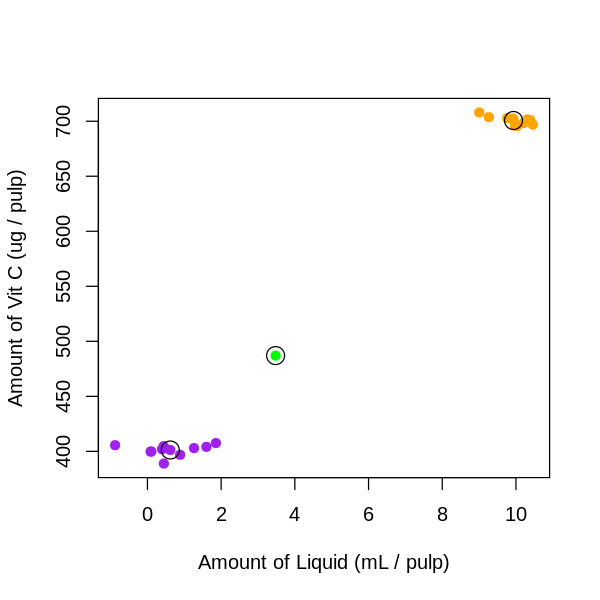

In [5]:
options(repr.plot.height=5, repr.plot.width = 5)
plot(df$liquid.amount, df$vit.c.amount, 
     col = factor(df$fruit.class), pch = 19, 
     xlab = "Amount of Liquid (mL / pulp)", ylab = "Amount of Vit C (ug / pulp)", 
     )# xlim = c(min(df$liquid.amount),mixture.values[2]), ylim = c(min(df$vit.c.amount),mixture.values[1]))
points(c(mixture.values[2], mixture.values[2]), c(mixture.values[1], mixture.values[1]), pch = c(19, 1), col = c('green', 'black'), cex = c(1,2))
points(centroids$liquid.amount, centroids$vit.c.amount, col = c("purple", 'orange'), pch = 19)
points(centroids$liquid.amount, centroids$vit.c.amount, col = c("black"), cex = 2, pch = 1)

In [6]:
prop <- solve(t(centroids), (mixture.values)) 
prop / sum(prop) * length(smoothie.fruits)

table(df$fruit.class[smoothie.fruits])

grape   orange 
4.810043 2.189957


 grape orange 
     5      2 

### Generalization
Instead of oranges and grapes, lets have cardiomycoytes and fibroblasts.

Instead of vitamin C content and amount of liquid, lets have Nppb, Postn, Cilp, Gm122831, ..., gene10000, etc.

The difference here is we went from 2 classes with 2 dimensions of measurement, to 2 classes with 1000s of dimensions of measurement. The challenge now is feature selection and condensation!

## Intuition behind v-SVM

### Technique for reducing dimensions
There are may **linear** ways to reduce dimensions including PCA, LDA, and SVM. In this paper, the authors opted to use SVM or support vector machines to efficiently carve up feature space to discriminate between unique classes of cells. Different methods have pros and cons, and which is best to chose is context dependent. In our case, we know what the category of each observation is (orange or grape), but we want to concentrate them to correctly identify their centroid.

**BUT WHY DO WE NEED TO REDUCE DIMENSIONS?** Why do we need a way to go from 100s or even 1000s of genes down to just a few for our centroid method to work well? It is because of the curse of dimensionality. As the number of measurements grows, the data tends to spread out more and no longer form easily discernable clusters that we can instantly see a pattern from. e.g. In very high dimensions, grapes and oranges may not look all that different.

### Idea behind SVM
SVM stands for support vector machine. This technique's scary and impressive name belies a very simple concept: **seperate oranges from grapes as efficiently as possible.**

In [73]:
set.seed(5)

vit_c_amount = c(rnorm(10, mean = 705, sd = 5), rnorm(10, mean = 700, sd = 5))
liquid_amount = c(rnorm(10, mean = 5, sd = 0.5), rnorm(10, mean = 4, sd = 0.5))
fruit_class = c(rep("orange", 10), rep("grape", 10))

# Oranges have 10 pulp and grapes have 1 pulp
df = data.frame(vit.c.amount = vit_c_amount, liquid.amount = liquid_amount, fruit.class = fruit_class)
head(df)

,vit.c.amount,liquid.amount,fruit.class
,<dbl>,<dbl>,<chr>
1,700.7957,5.450256,orange
2,711.9218,5.470935,orange
3,698.7225,5.733981,orange
4,705.3507,5.353381,orange
5,713.5572,5.409504,orange
6,701.9855,4.853259,orange


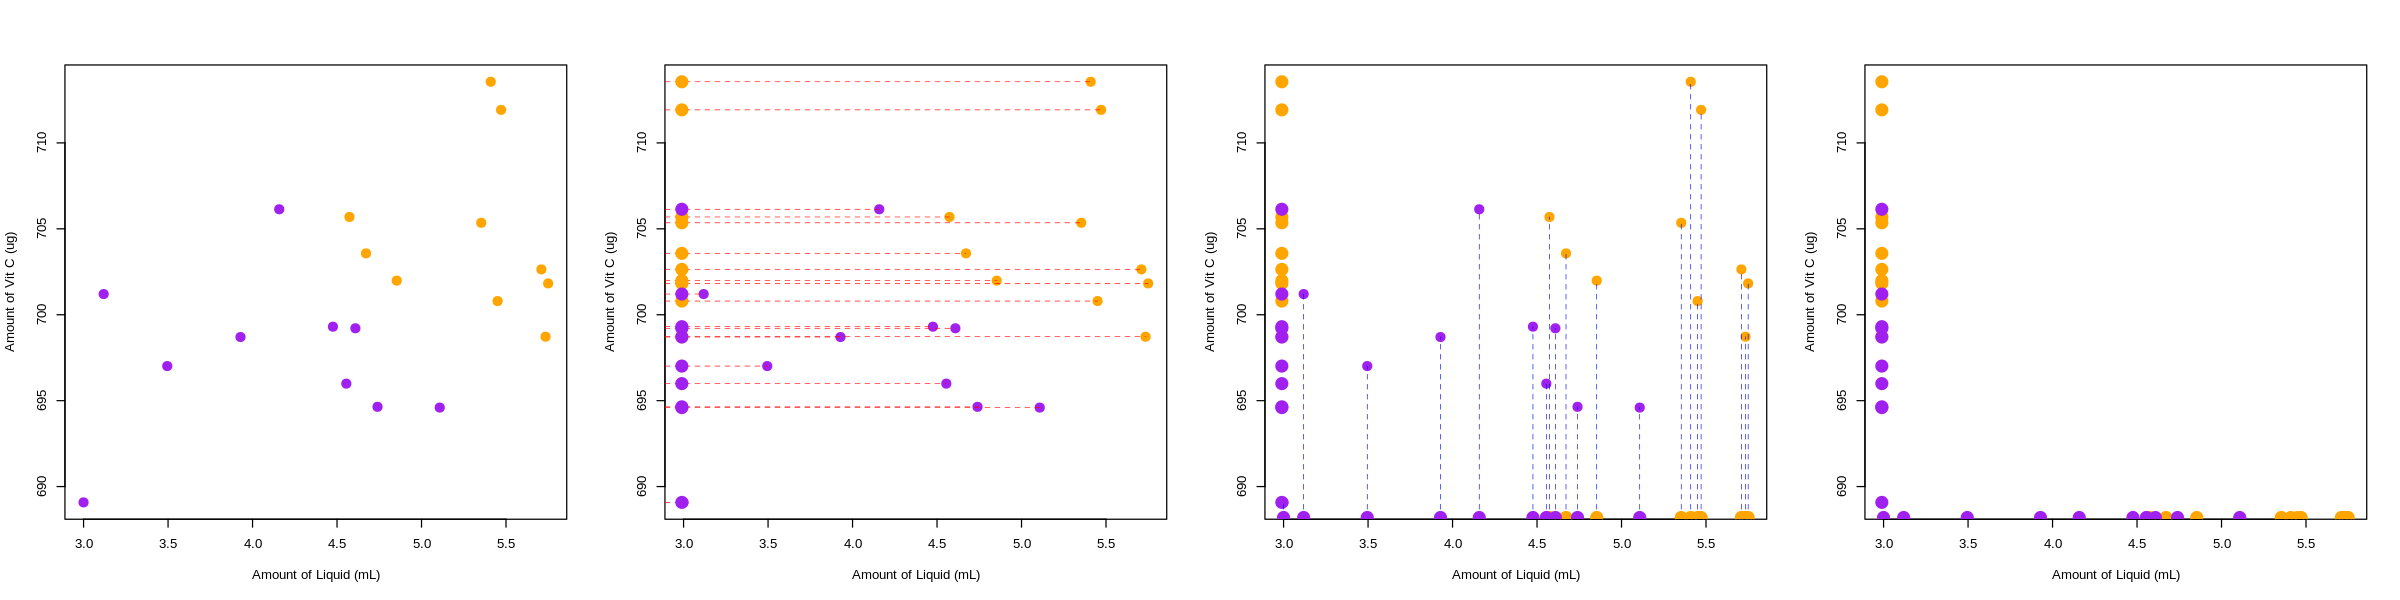

In [74]:
options(repr.plot.height=5, repr.plot.width = 20)
par(mfrow = c(1,4))

plot(df$liquid.amount, df$vit.c.amount, 
     col = factor(df$fruit.class), pch = 19, 
     xlab = "Amount of Liquid (mL)", ylab = "Amount of Vit C (ug)", cex = 1.5
     )
#############################################################################################
plot(df$liquid.amount, df$vit.c.amount, 
     col = factor(df$fruit.class), pch = 19, 
     xlab = "Amount of Liquid (mL)", ylab = "Amount of Vit C (ug)", cex = 1.5
     )
xmin = par('usr')[1]
xmax = par('usr')[2]
ymin = par('usr')[3]
ymax = par('usr')[4]
segments(x0 = rep(xmin, 20), y0 = df$vit.c.amount, x1 = df$liquid.amount, y1 = df$vit.c.amount, col = 'red', lty = 'dashed', lwd = 0.5)
points(x = rep(xmin+0.1,20), y = df$vit.c.amount, col = factor(df$fruit.class), pch = 19, cex = 2)
#############################################################################################
plot(df$liquid.amount, df$vit.c.amount, 
     col = factor(df$fruit.class), pch = 19, 
     xlab = "Amount of Liquid (mL)", ylab = "Amount of Vit C (ug)", cex = 1.5
     )
xmin = par('usr')[1]
xmax = par('usr')[2]
ymin = par('usr')[3]
ymax = par('usr')[4]
points(x = rep(xmin+0.1,20), y = df$vit.c.amount, col = factor(df$fruit.class), pch = 19, cex = 2)

segments(x0 = df$liquid.amount, y0 = rep(ymin, 20), x1 = df$liquid.amount, y1 = df$vit.c.amount, col = 'blue', lty = 'dashed', lwd = 0.5)
points(x = df$liquid.amount, y = rep(ymin+0.1,20), col = factor(df$fruit.class), pch = 19, cex = 2)
#############################################################################################
plot(df$liquid.amount, df$vit.c.amount, 
     col = 'white', pch = 19, 
     xlab = "Amount of Liquid (mL)", ylab = "Amount of Vit C (ug)", cex = 1.5
     )
xmin = par('usr')[1]
xmax = par('usr')[2]
ymin = par('usr')[3]
ymax = par('usr')[4]
points(x = rep(xmin+0.1,20), y = df$vit.c.amount, col = factor(df$fruit.class), pch = 19, cex = 2)
points(x = df$liquid.amount, y = rep(ymin+0.1,20), col = factor(df$fruit.class), pch = 19, cex = 2)

Both measurements contain valuable information, but neither on their own give me a perfect way to seperate oranges from grapes. As a human looking at the far left graph, I would draw a line like this to seprate the two.

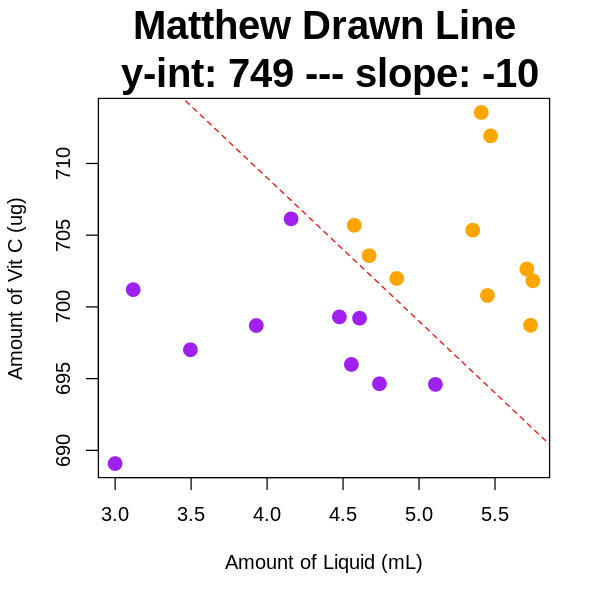

In [115]:
options(repr.plot.height=5, repr.plot.width = 5)

plot(df$liquid.amount, df$vit.c.amount, 
     col = factor(df$fruit.class), pch = 19, cex = 1.5, 
     xlab = "Amount of Liquid (mL)", 
     ylab = "Amount of Vit C (ug)", 
     main = paste0("Matthew Drawn Line\n y-int: 749 --- slope: -10"), 
     cex.main = 2
     )
abline(a = 749, b = -10, lty = 2, col = 'red')

This is how an svm would draw the line

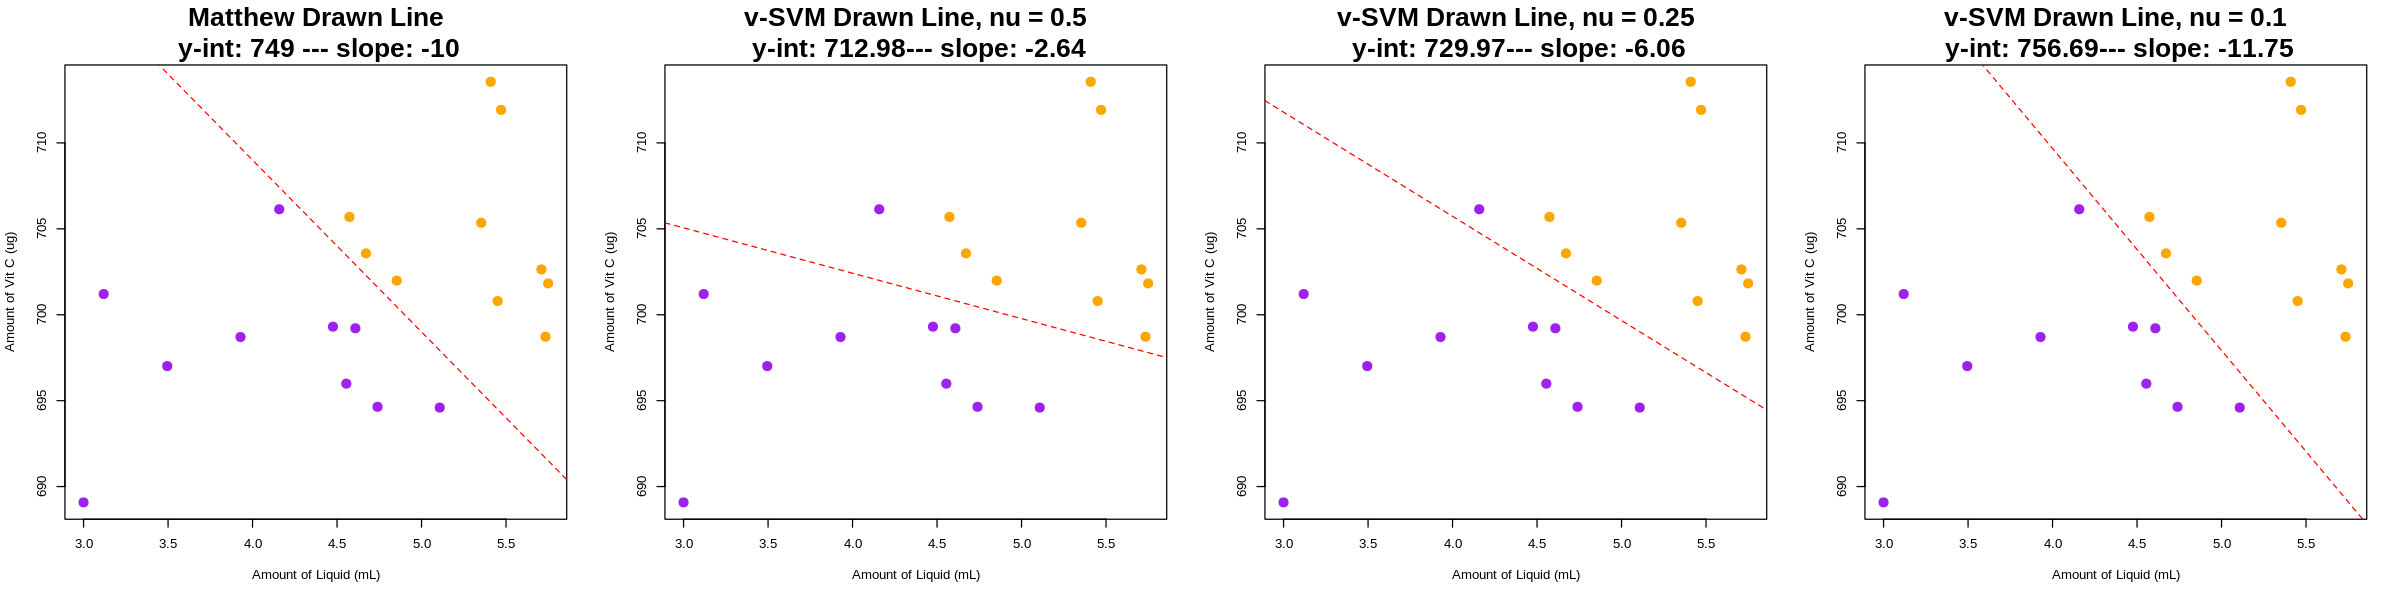

In [116]:
options(repr.plot.height=5, repr.plot.width = 20)
par(mfrow = c(1,4))

x = df[,c("vit.c.amount", "liquid.amount")]
y = factor(df$fruit.class)
nu.vector <- c(0.5, 0.25, 0.1)

plot(df$liquid.amount, df$vit.c.amount, 
     col = factor(df$fruit.class), pch = 19, cex = 1.5, 
     xlab = "Amount of Liquid (mL)", 
     ylab = "Amount of Vit C (ug)", 
     main = paste0("Matthew Drawn Line\n y-int: 749 --- slope: -10"), 
     cex.main = 2
     )
abline(a = 749, b = -10, lty = 2, col = 'red')

for(nu in nu.vector){
    svmfit = svm(x = x, y = y, kernel = "linear", nu = nu, scale = FALSE, type = 'nu-classification')
    beta = drop(t(svmfit$coefs)%*%as.matrix(x[svmfit$index,]))
    beta0 = svmfit$rho
    plot(df$liquid.amount, df$vit.c.amount, 
         col = factor(df$fruit.class), pch = 19, cex = 1.5, 
         xlab = "Amount of Liquid (mL)", 
         ylab = "Amount of Vit C (ug)", 
         main = paste0("v-SVM Drawn Line, nu = ", nu, "\n y-int: ", round(beta0 / beta["vit.c.amount"], 2), "--- slope: ", round(-beta["liquid.amount"] / beta["vit.c.amount"], 2)), 
         cex.main = 2
         )
    abline(a = beta0 / beta["vit.c.amount"], b = -beta["liquid.amount"] / beta["vit.c.amount"], lty = 2, col = 'red')
    }

## Applying SVM to real problems
Okay, we can draw a line between two populations, so what?

Lets remember why we are doing this. My example is in 2D space, and in low dimensional space, reducing it further doesn't seem very impressive. However, what we have done is profound. If each axis is a dimension, then SVM let us summarize two dimensions with only one as good as, if not better than a human could. We needed a tool that could squish dimensions, well we got one. The beautiful part is this technique generalizes incredibly well to huge numbers of dimensions and lets us seperate and condense celltypes!

A real life example of running this algorithm on single cell data looks like this. Here we have a downsampled single nucleus TT034 experiment for signature matrix construction, and we will be testing our technique on TT034 bulk tissue samples. I have relatively high resolution for subcelltypes, but here we will only look at the major celltype proportions.

In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(leaps)
    library(plyr)
    library(dplyr)
    library(glmnet)
    library(data.table)
    library(MASS)
    library(MCMCprecision)
    library(parallel)
    library(ggplot2)
    library(e1071)
    }))
`%!in%` <- Negate(`%in%`)

setwd("/mnt/c/Users/mkozubov/OneDrive - Tenaya Therapeutics/Desktop/Intuitions/Statistics/SVM/")

# Before running the """"import for the first time"""", 
# write.table is funky and doesn't play nice with fread
# because it omits the first comma the way I have it written, so on the commandline enter
# `sed -i '1s/^/,/' filename.txt` to pre-append a comma

count.mat <- fread('../Linear_regression//data/tt034_full_small_counts.csv', 
                 data.table = FALSE, 
                 check.names = FALSE, 
                 stringsAsFactors = FALSE, 
                 header = TRUE, 
                 sep = ",")
# Fixing rownames
rownames(count.mat) <- count.mat[,1]
count.mat$V1 <- NULL

# I am going to get rid of the Gm genes because I feel they pollute my results
cols.to.remove <- colnames(count.mat)[grepl("^Gm[0-9]{4,9}", colnames(count.mat))]
count.mat <- count.mat[colnames(count.mat) %!in% cols.to.remove]

# I will extract the meta data col and make it its own thing
meta.mat <- count.mat[,dim(count.mat)[2], drop=F]
meta.mat$ident <- unname(sapply(meta.mat$ident, FUN = function(x){strsplit(x, "_")[[1]][1]}))
# meta.mat <- read.table(file = "./data//meta_data2.csv", sep=',')
celltypes <- unique(meta.mat$ident)
count.mat[,dim(count.mat)[2]] <- NULL

dim(count.mat)
dim(meta.mat)

[1]  2954 19351

[1] 2954    1

In [2]:
pseudobulk <- read.table("../Linear_regression//data/TT034_TranscriptMatrixSalmon.counts.txt", header = T, row.names = 1)
pseudo.bulk.count <- pseudobulk[1]
colnames(pseudo.bulk.count) <- 'pseudo.bulk'

In [3]:
# Function to perform wilcox.test for one group vs all others
wilcox_one_vs_all <- function(data, meta.data, group.by, group) {
    # Same function without variable assignments
    return( wilcox.test(data[meta.data[[group.by]] == group], 
                                    data[meta.data[[group.by]] != group], 
                                    paired = FALSE)$p.value 
          )
}

# Function to perform log2FC for one group vs all others
log2FC_one_vs_all <- function(data, meta.data, group.by, group) {
    # Same function without variable assignments
    return( log2(mean(data[meta.data[[group.by]] == group]) / mean(data[meta.data[[group.by]] != group])) )
}

# # Parallel version of the function that takes 76.963 seconds
cl <- makeCluster(3)

system.time(
marker.list <- do.call(rbind, lapply(celltypes, FUN = function(y){ 
                clusterExport(cl = cl, varlist = c("count.mat", "meta.mat", "y", 'wilcox_one_vs_all', 'log2FC_one_vs_all'), envir=environment())
                thing <- as.data.frame(t(parApply(count.mat, MARGIN = 2, FUN = function(x){
                    return(c("p.val"  = wilcox_one_vs_all(x, meta.data = meta.mat, group.by = 'ident', group = y), 
                             "log2FC" = log2FC_one_vs_all(x, meta.data = meta.mat, group.by = 'ident', group = y),
                             "cluster" = y))
                }, 
                                                  cl = cl)))
                thing$gene <- rownames(thing)
                return(thing)
    }))
)
marker.list$p.val[is.nan(marker.list$p.val)] <- 1
marker.list$log2FC[is.nan(marker.list$log2FC)] <- 0
marker.list$p.val <- as.numeric(marker.list$p.val)
marker.list$log2FC <- as.numeric(marker.list$log2FC)

marker.list$p.val.adjust <- p.adjust(marker.list$p.val, method = "bonferroni")
marker.list$p.val.adjust.cor <- marker.list$p.val.adjust + 2.225074e-308
marker.list$sort.metric <- -log10(marker.list$p.val.adjust.cor) * sign(marker.list$log2FC)
dim(marker.list)

marker.list.filt <- marker.list[marker.list$sort.metric > 0,]
topMarkers100 <- marker.list.filt %>% group_by(cluster) %>% top_n(100, wt=sort.metric) %>% top_n(100, wt=log2FC)
saveRDS(topMarkers100, file = "../Linear_regression//data/topMarkers_tt034_full_100.rds")
# topMarkers100 <- readRDS("../Linear_regression/data/topMarkers_tt034_full_100.rds")

   user  system elapsed 
 29.037   4.690 180.569 

[1] 96755     7

In [4]:
cellprop.estimate <- list()
beta.list <- list()
rho.list <- list()

genes.to.go.forward.with <- topMarkers100$gene[topMarkers100$gene %in% rownames(pseudo.bulk.count)] # gotta make sure that the genes are in the dataset
# Works in the idealized case
x = count.mat[,genes.to.go.forward.with] 
x = x / apply(x, 1, sum) * 1e6
x.test = pseudo.bulk.count[genes.to.go.forward.with,"pseudo.bulk"]
x.test = x.test / sum(x.test) * 1e6

cl = makeCluster(3)
clusterExport(cl = cl, varlist = c("x", "celltypes", "meta.mat", "svm"))

system.time(
    thing <- parLapply(celltypes, fun = function(celltype){
        group = factor(ifelse(meta.mat$ident == celltype, celltype, 'other'), levels = c(celltype, 'other'), ordered = T)
        svmfit = svm(x = x, y = group, kernel = "linear", nu = 0.05, scale = FALSE, type = 'nu-classification')
    }, cl = cl)
    )

beta.list <- lapply(thing, function(svmfit) { drop(t(svmfit$coefs)%*%as.matrix(x[svmfit$index,])) })
rho.list <- lapply(thing, function(svmfit) { svmfit$rho })

names(rho.list) <- celltypes
rho.list <- unlist(rho.list)
names(beta.list) <- celltypes
beta.list <- as.data.frame(beta.list)

   user  system elapsed 
  0.015   0.001   2.376 

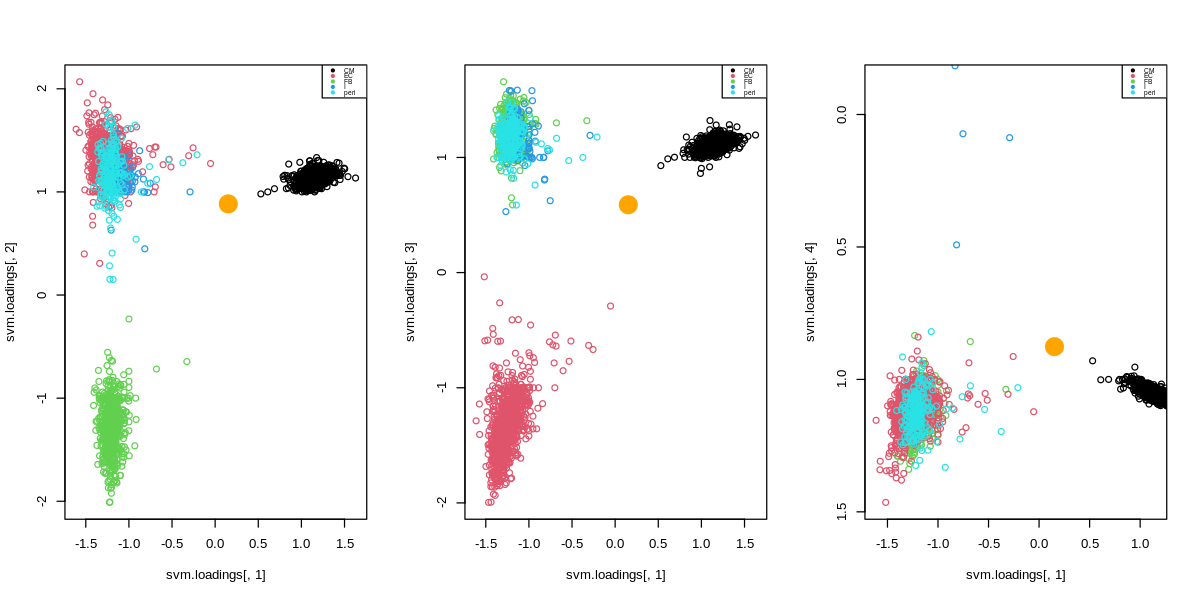

In [5]:
svm.loadings <- as.matrix(x) %*% as.matrix(beta.list) 
svm.loadings <- t(apply(svm.loadings, MARGIN = 1, function(x){ x - rho.list}))
pseudo.bulk.svm.loading <- t(x.test) %*% as.matrix(beta.list) - rho.list

options(repr.plot.height=5, repr.plot.width = 10)
group = factor(meta.mat$ident)
par(mfrow = c(1,3))
plot(svm.loadings[,1], 
     svm.loadings[,2], 
     col = group)
points(pseudo.bulk.svm.loading[,1], 
       pseudo.bulk.svm.loading[,2], 
       col = 'orange', pch = 19, cex = 3)
legend("topright", legend = levels(group), col = 1:length(levels(group)), pch = 19, cex = 0.5)

plot(svm.loadings[,1], 
     svm.loadings[,3], 
     col = group)
points(pseudo.bulk.svm.loading[,1], 
       pseudo.bulk.svm.loading[,3], 
       col = 'orange', pch = 19, cex = 3)
legend("topright", legend = levels(group), col = 1:length(levels(group)), pch = 19, cex = 0.5)

plot(svm.loadings[,1], 
     svm.loadings[,4], 
     col = group, 
     xlim = c((min(svm.loadings[,1]) + 0), pseudo.bulk.svm.loading[,1]+1), 
     ylim = c(max(svm.loadings[,4]), pseudo.bulk.svm.loading[,4]-1))
points(pseudo.bulk.svm.loading[,1], 
       pseudo.bulk.svm.loading[,4], 
       col = 'orange', pch = 19, cex = 3)
legend("topright", legend = levels(group), col = 1:length(levels(group)), pch = 19, cex = 0.5)

In [7]:
A <- t(apply(svm.loadings, MARGIN = 2, function(x) tapply(x, group, mean))); rownames(A) <- paste0(rownames(A), "_SVM"); A

# Vector of constants
b <- as.numeric(pseudo.bulk.svm.loading)

pred.cell.prop <- solve(A, b)
(pred.cell.prop / sum(pred.cell.prop))

,CM,EC,FB,I,peri
CM_SVM,1.163178,-1.253451,-1.198592,-1.1095863,-1.189939
FB_SVM,1.142885,1.334114,-1.282146,1.1621027,1.179141
EC_SVM,1.112496,-1.334974,1.221123,1.1618889,1.169629
I_SVM,1.055536,1.110404,1.125527,-0.9164656,1.124732
peri_SVM,1.232676,1.437583,1.333982,1.2228191,-1.059374


CM          EC          FB           I        peri 
 0.57207882  0.22563335  0.13180833  0.10889376 -0.03841426

# Results and future directions
Here I summarized almost a thousand dimensions into 4. These 4 dimensions appear to have tight boundries and would be great for applying to the deconvolution technique we previously learned. Unfortunately, the discordance between my single nucleus signature matrix and the bulk data is producing the result in the third figure where the bulk doesn't appear as a linear combination of the signature despite being normalized in a similar fashion. I need to test if this is a product of
1. Single nucleus being a bad representation of bulk data
1. Batch effect existing between single nucleus and bulk sequencing experiments (CibersortX has a solution called S-mode batch correction)
1. Signature matrix not being representative of the cell populations existing in the bulk data (only CMs here, need all celltypes to truly be representative)
1. Solving the matrix without applying constraints to ensure the betas are 0<beta<1.

The solutions to each of these problems would be
1. Get a single cell experiment and do the same procedure and see if bulk (yellow dot) now appears in the middle of the signature cells.
1. Implement CiberSort's batch effect removal scheme.
1. Downsample the whole TT034 with 500 cells per celltype and rebuild the model.
1. Learn how to and incorporate constraints to the linear equation solution